In [1]:
! pip install kaggle

In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp /content/kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:12<00:00, 215MB/s]
100% 2.29G/2.29G [00:12<00:00, 195MB/s]


In [12]:
from zipfile import ZipFile
file_name = "/content/chest-xray-pneumonia.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


>### Import the necessary packages

In [13]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

>### Loading the data

In [14]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

>### Data Augmentation
>* Using ImageDataGenerator, to augment our images so as to create a larger dataset 

In [15]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [16]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',

                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',

                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',

                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
img, label = next(train)

>###    Defining the model
>*    Using pre-trainied VGG19 model.
>*    Freezing all the layers of model of train.
>*    Using Adam as optimizer and binary_crossentropy as loss function.
>*    Using callbacks for avoiding overfitting case.

In [18]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)


80150528/80134624 [==============================] - 1s 0us/step


In [19]:
# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

In [20]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [22]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 117s 1s/step - loss: 0.4866 - accuracy: 0.7722 - val_loss: 0.5492 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 100s 994ms/step - loss: 0.4226 - accuracy: 0.8078 - val_loss: 0.5003 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 99s 986ms/step - loss: 0.3863 - accuracy: 0.8213 - val_loss: 0.4501 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 101s 1s/step - loss: 0.3635 - accuracy: 0.8325 - val_loss: 0.4221 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 97s 972ms/step - loss: 0.3540 - accuracy: 0.8353 - val_loss: 0.4426 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 99s 991ms/step - loss: 0.3315 - accuracy: 0.8553 - val_loss: 0.4166 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 9

>### Evaluating VGG19

In [23]:
score=model.evaluate(train)

163/163 [==============================] - 169s 1s/step - loss: 0.2648 - accuracy: 0.8932


In [24]:
# train data
print("Train Accuracy:",score[1])

Train Accuracy: 0.8932132124900818


In [27]:
score=model.evaluate(test)
# train data
print("Test Accuracy:",score[1])

312/312 [==============================] - 29s 91ms/step - loss: 0.4459 - accuracy: 0.7740
Test Accuracy: 0.7740384340286255


Text(0.5, 1.0, 'Accuracy Evolution')

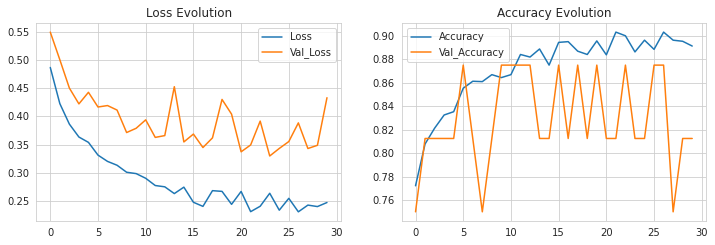

In [28]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')